# Week 4

### How to Deal with Experimantal Spectrum which may contain Errors?

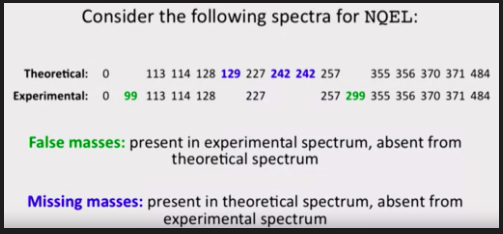

In [3]:
with open('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_3-4/integer_mass_table.txt') as mass_file:
    mass_dict = {
        line.split()[0]: int(line.split()[-1]) for line in mass_file.readlines()
    }

print(mass_dict)

with open('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_3-4/integer_mass_table.txt') as mass_file:
    reversed_mass_dict_simplified = { # здесь мы не отличаем аминокислоты с одинаковыми массами
        int(line.split()[-1]): line.split()[0] for line in mass_file.readlines()
    }

print(reversed_mass_dict_simplified)

{'G': 57, 'A': 71, 'S': 87, 'P': 97, 'V': 99, 'T': 101, 'C': 103, 'I': 113, 'L': 113, 'N': 114, 'D': 115, 'K': 128, 'Q': 128, 'E': 129, 'M': 131, 'H': 137, 'F': 147, 'R': 156, 'Y': 163, 'W': 186}
{57: 'G', 71: 'A', 87: 'S', 97: 'P', 99: 'V', 101: 'T', 103: 'C', 113: 'L', 114: 'N', 115: 'D', 128: 'Q', 129: 'E', 131: 'M', 137: 'H', 147: 'F', 156: 'R', 163: 'Y', 186: 'W'}


### Functions from Week 3

In [283]:
def CountMass(Peptide):
    return sum([ mass_dict[aminoacid] for aminoacid in Peptide ])


def SubpeptidesLinear(Peptide:str):
    return sorted([ Peptide[i:i+j] for i in range(len(Peptide)) for j in range(1, len(Peptide)-i+1) ], key=len)


def SubpeptidesCyclic(Peptide:str):
    cycle = Peptide + Peptide
    return [ cycle[i:i+j] for j in range(1, len(Peptide)) for i in range(len(Peptide)) ] + [ Peptide ]


def MassSpectrum(Peptide:str, mode="C"):
    if mode in ["C", "Cyclic"]:
        Peptides = SubpeptidesCyclic(Peptide=Peptide)
    elif mode in ["L", "Linear"]:
        Peptides = SubpeptidesLinear(Peptide=Peptide)
    else:
        return "Wrong mode used, please select from following: C L Cyclic Linear"

    massSpec = [ CountMass(fragment) for  fragment in Peptides ]
    massSpec.insert(0, 0)
    return sorted(massSpec)


def CheckConsistentPeptideCyclic(Peptide, Spectrum):
    '''
    Function to check, if Peptide is Consistent - if all linear subpeptides present in Spectrum
    '''
    return all([CountMass(peptide) in Spectrum for peptide in SubpeptidesCyclic(Peptide)])


def CheckConsistentPeptideLinear(Peptide, Spectrum):
    '''
    Function to check, if Peptide is Consistent - if all linear subpeptides present in Spectrum
    '''
    return all([CountMass(peptide) in Spectrum for peptide in SubpeptidesLinear(Peptide)])

In [284]:
MassSpectrum(Peptide="NQEL", mode="C")

[0, 113, 114, 128, 129, 227, 242, 242, 257, 355, 356, 370, 371, 484]

In [285]:
MassSpectrum(Peptide="NQEL", mode="L")

[0, 113, 114, 128, 129, 242, 242, 257, 370, 371, 484]

### LeaderboardCyclopeptideSequencing.

First we need to define Score as number of mathces between Theoretical and Experimental Spectra for Peptide

#### Score Function

In [130]:
from collections import Counter


def ScorePeptideLetters(Peptide:str, Spectrum:list, mode:str):
    '''
    Function to count Score of similarity between theoratical and experimental spectra. Can work with Linear and Cyclic versions.
    It sums minimal frequencies of masses, which exist in both dictionaries.
    '''
    TheoreticalFreqDict = Counter(MassSpectrum(Peptide, mode=mode))
    ExperimentalFreqDict = Counter(Spectrum)

    return sum([ 
        min(TheoreticalFreqDict[mass], ExperimentalFreqDict[mass]) 
        for mass in TheoreticalFreqDict if mass in ExperimentalFreqDict ])

In [132]:
ScorePeptideLetters(
    Peptide="NQEL", Spectrum=[0, 99, 113, 114, 128, 227, 257, 299, 355, 356, 370, 371, 484], mode="C"
)

11

We now can redefine the Cyclopeptide Sequencing Problem for noisy spectra:

#### Cyclopeptide Sequencing Problem (for spectra with errors): 
Find a cyclic peptide having maximum score against an experimental spectrum.

Input: A collection of integers Spectrum.

Output: A cyclic peptide Peptide maximizing Score(Peptide, Spectrum) over all peptides Peptide with mass equal to ParentMass(Spectrum).


In [275]:
from collections import Counter


def ExpandPeptides(Peptides, Spectrum):
    '''
    Function to expand Peptide with 1 aminoacid and keep it
    '''
    Peptides = [ i for i in Peptides if i ]
    return { 
        (str(peptide) + '-' + str(aminoacid)): {
            "score": ScorePeptideMasses(Peptide=str(peptide)+'-'+str(aminoacid) , Spectrum=Spectrum),
            "mass": sum([int(i) for i in peptide.split('-')]) + int(aminoacid)
        } for peptide in Peptides for aminoacid in reversed_mass_dict_simplified
    }


def ScorePeptideMasses(Peptide:str, Spectrum:list, mode="L"):
    '''
    Function to count Score of similarity between theoratical and experimental spectra. Can work with Linear and Cyclic versions.
    It sums minimal frequencies of masses, which exist in both dictionaries.
    '''
    if mode == "C":
        TheoreticalFreqDict = Counter([ sum([int(i) for i in item]) for item in SubpeptidesCyclic(Peptide.split('-')) ])
    elif mode == "L":
        TheoreticalFreqDict = Counter([ sum([int(i) for i in item]) for item in SubpeptidesLinear(Peptide.split('-')) ])
    ExperimentalFreqDict = Counter(Spectrum)

    return sum([ 
        min(TheoreticalFreqDict[mass], ExperimentalFreqDict[mass]) 
        for mass in TheoreticalFreqDict if mass in ExperimentalFreqDict ])


def TrimPeptidesByScore(Peptides:dict, N:int):
    return {
        peptide: {"score": Peptides[peptide]["score"], "mass": Peptides[peptide]["mass"]}
        for peptide in Peptides if Peptides[peptide]["score"] in sorted(
            set([Peptides[key]["score"] for key in Peptides]), reverse=True)[:N]
    }

In [279]:
import math


def LeaderboardCyclopeptideSequencing(Spectrum:list, N:int):
    LeaderPeptide = "0"
    LeaderBoard = { str(aminoacid): {
        "score": ScorePeptideMasses(Peptide=str(aminoacid), Spectrum=Spectrum),
        "mass": aminoacid
     } for aminoacid in reversed_mass_dict_simplified}
    LeaderBoard = TrimPeptidesByScore(LeaderBoard, N)
    print(LeaderBoard)

    while LeaderBoard:
        N = math.ceil(N/2)
        for peptide in LeaderBoard:
            if LeaderBoard[peptide]["mass"] == max(Spectrum):
                if LeaderBoard[peptide]["score"] > ScorePeptideMasses(LeaderPeptide, Spectrum, mode="C"):
                    print("Look!\t", peptide, LeaderBoard[peptide])
                    LeaderPeptide = peptide
            elif LeaderBoard[peptide]["mass"] > max(Spectrum):
                LeaderBoard = { key:LeaderBoard[key] for key in LeaderBoard if key != peptide }

        print(LeaderPeptide)
        # print("After Trim:", LeaderBoard)
        LeaderBoard = ExpandPeptides(LeaderBoard, Spectrum)
        LeaderBoard = TrimPeptidesByScore(LeaderBoard, N)
        # print("After Extend:", LeaderBoard)

    return LeaderPeptide

Working too slow.. There are some advise in Notes, plus Use Charging Station to optimize trimmin function (and scoring may be)

In [281]:
LeaderboardCyclopeptideSequencing(
    Spectrum=[0, 71, 113, 129, 147, 200, 218, 260, 313, 331, 347, 389, 460], N=10
    # Spectrum=[int(i) for i in input().split()], N=325
)

{'57': {'score': 0, 'mass': 57}, '71': {'score': 1, 'mass': 71}, '87': {'score': 0, 'mass': 87}, '97': {'score': 0, 'mass': 97}, '99': {'score': 0, 'mass': 99}, '101': {'score': 0, 'mass': 101}, '103': {'score': 0, 'mass': 103}, '113': {'score': 1, 'mass': 113}, '114': {'score': 0, 'mass': 114}, '115': {'score': 0, 'mass': 115}, '128': {'score': 0, 'mass': 128}, '129': {'score': 1, 'mass': 129}, '131': {'score': 0, 'mass': 131}, '137': {'score': 0, 'mass': 137}, '147': {'score': 1, 'mass': 147}, '156': {'score': 0, 'mass': 156}, '163': {'score': 0, 'mass': 163}, '186': {'score': 0, 'mass': 186}}
0
0
0
Look!	 71-129-113-147 {'score': 9, 'mass': 460}
71-129-113-147
71-129-113-147


'71-129-113-147'